The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs.

In [1]:
# Import necessary libraries and set display options
# Import necessary libraries
from matplotlib.ticker import LogLocator, FuncFormatter
from scipy.integrate import quad
# Import GPD specific functions
import sys
sys.path.append('/mnt/c/Users/flori/Documents/PostDoc/Jupyter')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from joblib import Parallel, delayed
from scipy.special import gamma, digamma
import re
import os
from GPD_functions import *

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set width to avoid wrapping
pd.set_option('display.max_colwidth', None) # Show full content of each column

np.set_printoptions(linewidth=200)

In [2]:
# Check if data files are parsed correctly
for ID in publication_mapping:
    moment_type = "NonSingletIsovector"
    #moment_type = "NonSingletIsoscalar"
    moment_label = "A"
    
    print(f"Publication ID: {ID}")
    
    # Get the t_values and check if it's valid
    t_vals = t_values(moment_type, moment_label, ID)
    if t_vals is not None:
        print("t_values:", t_vals)
    else:
        continue
    
    # Iterate through n from 1 to 5
    for n in range(1, 6):
        print(f"Checking n = {n}")
        
        # Get the F{n}0 moment_type values and check if it's valid
        Fn0_vals = Fn0_values(n, moment_type, moment_label, ID)
        if Fn0_vals is not None:
            print(f"{moment_label}{n}0 {moment_type} values:", Fn0_vals)
        else:
            print(f"{moment_label}{n}0 {moment_type} values: No data available.")
        
        # Get the F{n}0 moment_type errors and check if it's valid
        Fn0_errs = Fn0_errors(n, moment_type, moment_label, ID)
        if Fn0_errs is not None:
            print(f"{moment_label}{n}0 {moment_type} errors:", Fn0_errs)
        else:
            print(f"{moment_label}{n}0 {moment_type} errors: No data available.")    

Publication ID: 2305.11117
t_values: [0.17 0.34 0.65 0.69 0.81 1.24 1.38 1.38 1.52 2.29 2.77]
Checking n = 1
A10 NonSingletIsovector values: [0.851 0.702 0.607 0.573 0.487 0.359 0.396 0.376 0.32  0.266 0.214]
A10 NonSingletIsovector errors: [0.0311 0.043  0.024  0.0146 0.031  0.0371 0.0042 0.021  0.0371 0.0662 0.013 ]
Checking n = 2
A20 NonSingletIsovector values: [0.247 0.205 0.193 0.187 0.168 0.145 0.137 0.129 0.131 0.115 0.101]
A20 NonSingletIsovector errors: [0.0117 0.0032 0.0098 0.0076 0.0092 0.012  0.0122 0.0092 0.014  0.0282 0.0071]
Checking n = 3
A30 NonSingletIsovector values: [0.086 0.078 0.068 0.07  0.068 0.064 0.053 0.05  0.047 0.048 0.035]
A30 NonSingletIsovector errors: [0.005  0.0054 0.0051 0.0054 0.0041 0.0063 0.0067 0.0041 0.0076 0.0149 0.0041]
Checking n = 4
A40 NonSingletIsovector values: [0.042 0.038 0.036 0.029 0.03  0.026 0.023 0.026 0.019 0.026 0.018]
A40 NonSingletIsovector errors: [0.0058 0.005  0.0054 0.0058 0.0042 0.0045 0.0036 0.0028 0.0041 0.0089 0.0036]
Ch

In [3]:
# Display the DataFrame
print("Parsed DataFrame:")
display(MSTWpdf)

Parsed DataFrame:


,Parameter,LO,NLO,NNLO
0,alpha_S(Q0^2),"[0.68183, 0, 0]","[0.49128, 0, 0]","[0.45077, 0, 0]"
1,alpha_S(M_Z^2),"[0.13939, 0, 0]","[0.12018, 0, 0]","[0.11707, 0, 0]"
2,A_u,"[1.4335, 0, 0]","[0.25871, 0, 0]","[0.2225, 0, 0]"
3,eta_1,"[0.45232, 0.022, -0.018]","[0.29065, 0.019, -0.013]","[0.27871, 0.018, -0.014]"
4,eta_2,"[3.0409, 0.079, -0.067]","[3.2432, 0.062, -0.039]","[3.3627, 0.061, -0.044]"
5,epsilon_u,"[-2.3737, 0.54, -0.48]","[4.0603, 1.6, -2.3]","[4.4343, 2.4, -2.7]"
6,gamma_u,"[8.9924, 0, 0]","[30.687, 0, 0]","[38.599, 0, 0]"
7,A_d,"[5.0903, 0, 0]","[12.288, 0, 0]","[17.938, 0, 0]"
8,eta_3,"[0.71978, 0.057, -0.082]","[0.96809, 0.11, -0.11]","[1.0839, 0.12, -0.11]"
9,eta_4-eta_2,"[2.0835, 0.32, -0.45]","[2.7003, 0.5, -0.52]","[2.7865, 0.5, -0.44]"


In [4]:
# Check momentum sum rule
def integrand(x):
    return x*(uv(x)+dv(x)+sv(x)+Sv(x)+gv(x))
result, error = quad(integrand,1e-6,1)
print(f"Check momentum sum rule")
print(np.isclose(result,1,rtol=1e-3,atol=1e-3))
del integrand, result, error

Check momentum sum rule
True


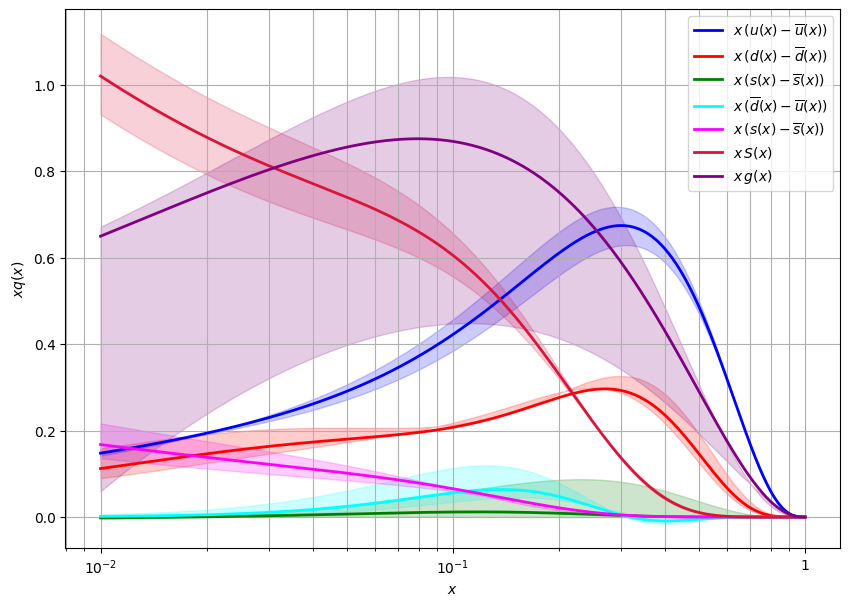

In [5]:
# Log Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.geomspace(1e-2, 1, 1000)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Customize ticks and labels
# Custom formatter function
def custom_log_formatter(val, pos):
    if val == 1:  # 10^0
        return "1"
    else:
        return f"$10^{{{int(np.log10(val))}}}$"
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))  # Major ticks at 10^n
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True,which="both")

# Display the plot
plt.show()


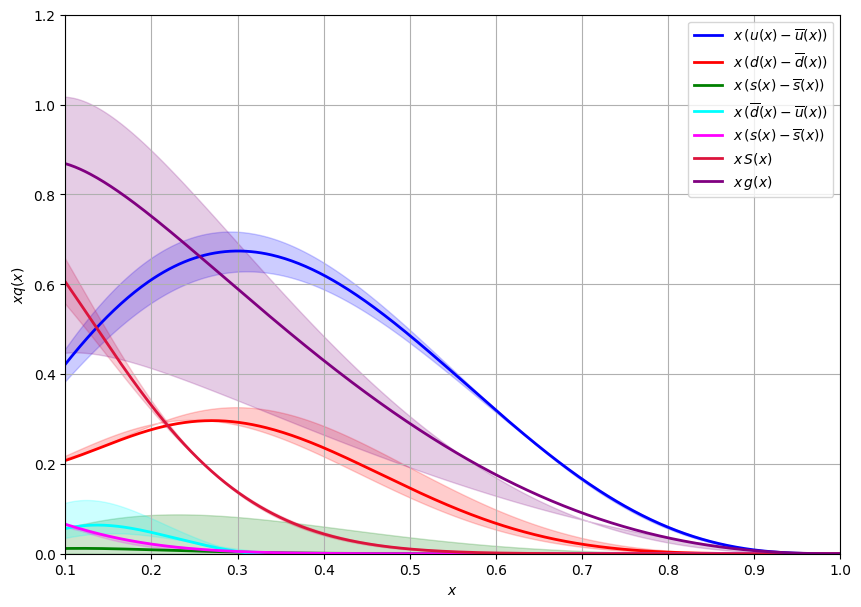

In [6]:
# Linear Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.linspace(1e-2, 1, 500)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")


# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))
# Specify plot range
plt.xlim(.1,1)
plt.ylim(0,1.2)

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


RGE evolution of $\alpha_s(Q^2)$

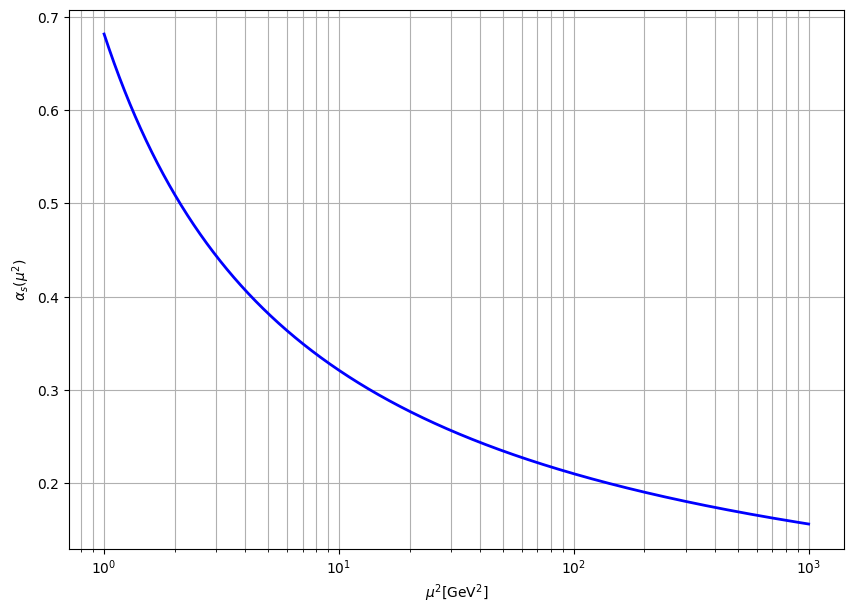

In [7]:
# Log Plot of RGE
# Define the range for x from .5 GeV**2 to 10 GeV**2
mu2_values = np.geomspace(1, 10**3, 10**4)
# mu2_values = np.linspace(1, 10**2, 10**3)

# Evolve alpha_s from mu2=1 GeV**2 on a mu2 grid
x_alpha_S= RGE_alpha_S(mu2_values)

# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Plot uv(x)
plt.plot(mu2_values, x_alpha_S, color="blue", linewidth=2)

# Set plot labels, legend, and grid
plt.xlabel("$\\mu^2[\mathrm{GeV}^2]$")
plt.ylabel("$\\alpha_s(\\mu^2)$")
plt.grid(True,which="both")

# Display the plot
plt.show()

Plots of conformal moments $\mathbb{G}_q(n,\eta,t)$ and their RGE evolution

Momentum space

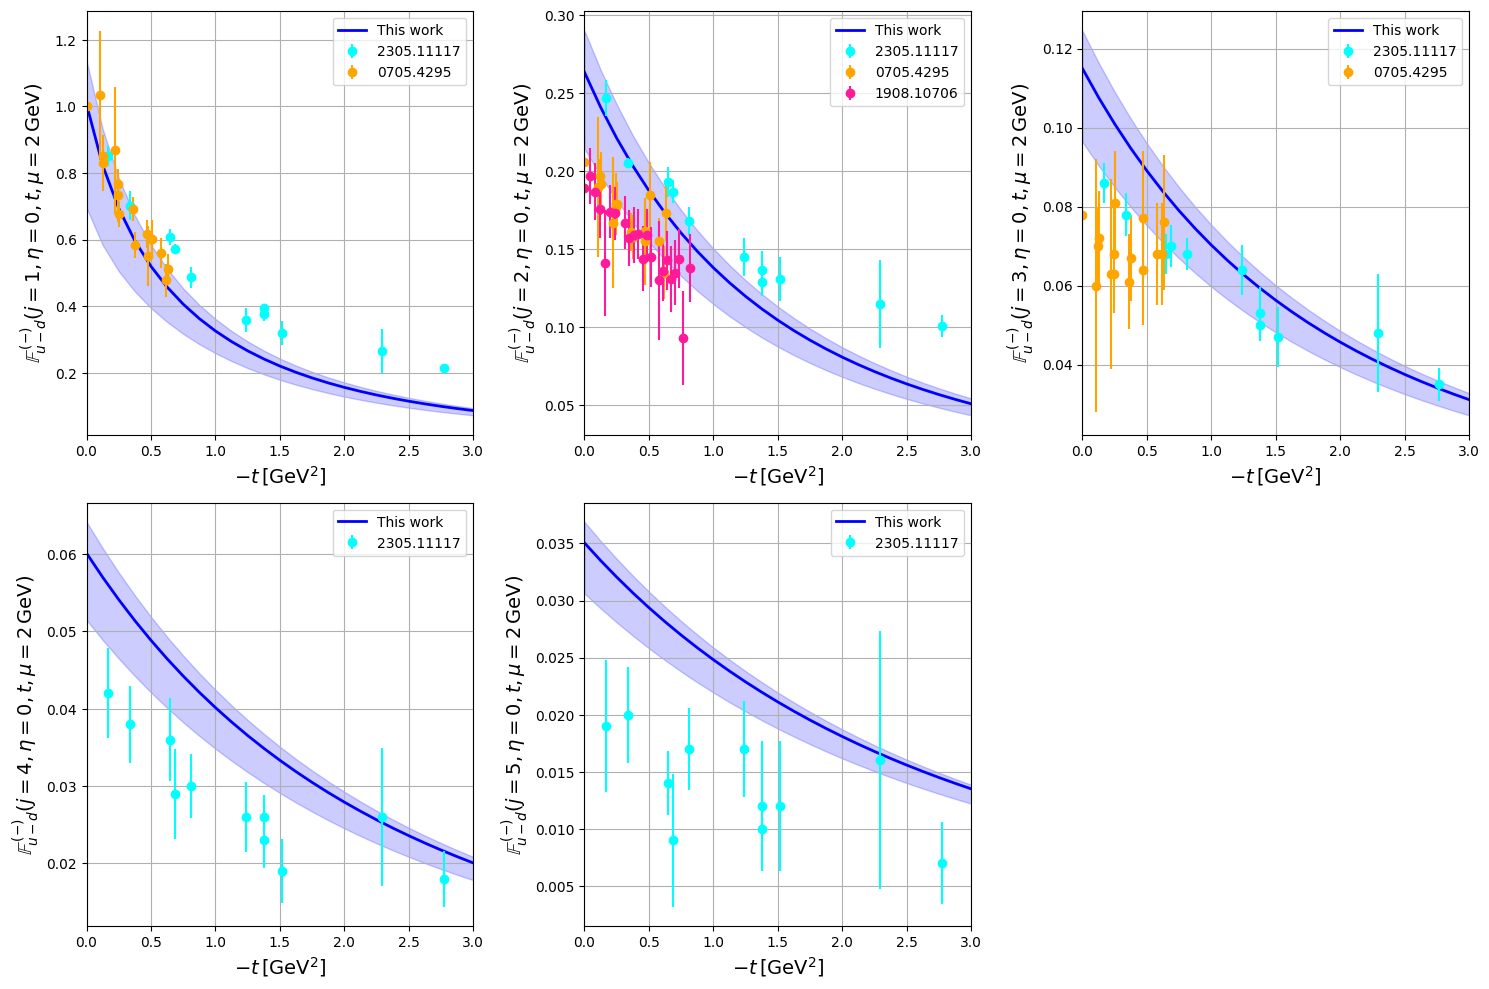

In [8]:
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"

plot_moments(moment_type, moment_label,y_label,3,25)

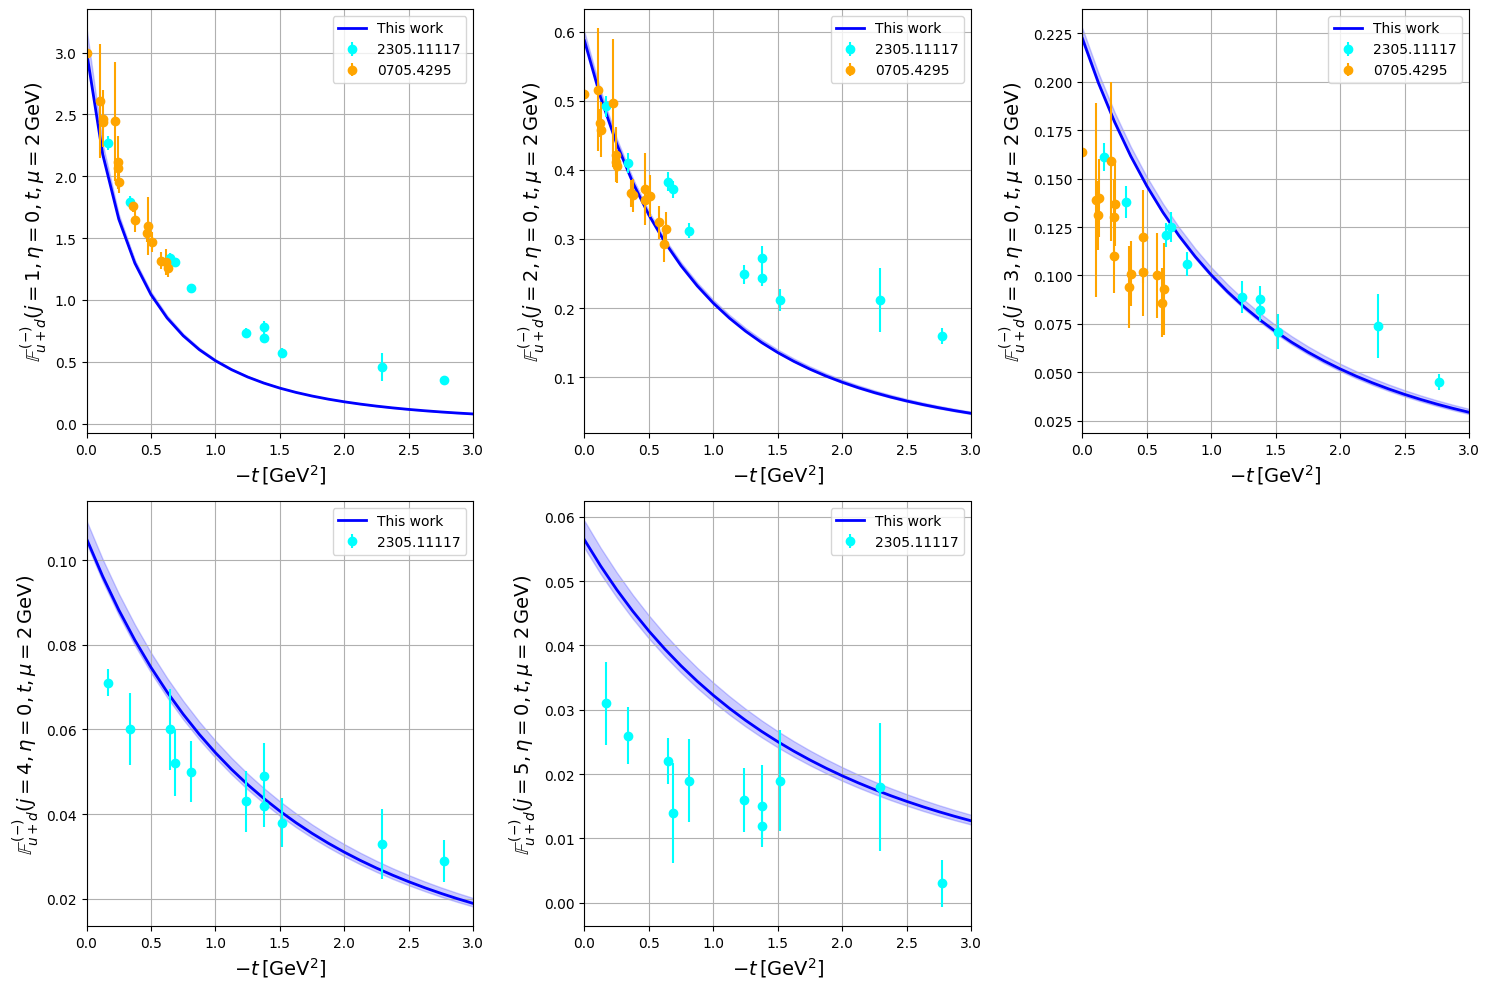

In [9]:
y_label = "$\\mathbb{{F}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "A"

plot_moments(moment_type, moment_label,y_label,3,25)

Impact parameter representation

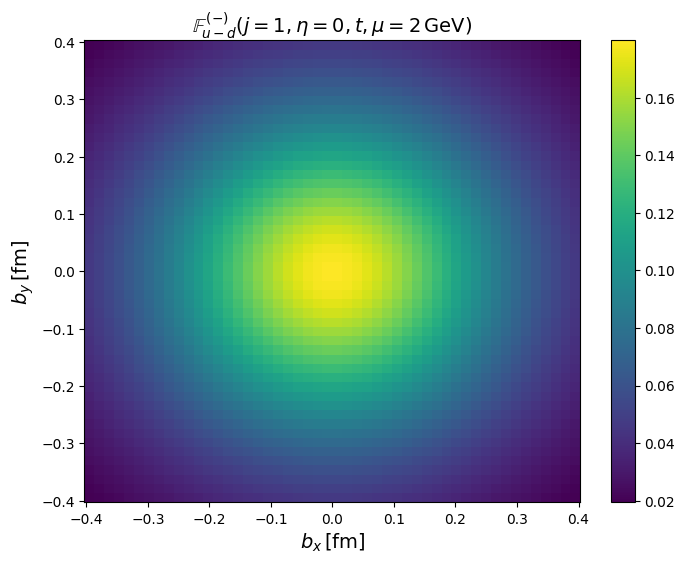

In [10]:
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_title = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
plot_ft_moments(moment_type,moment_label,plot_title, 1, 2)